<a href="https://colab.research.google.com/github/fernandopersan/4EscolaBigData/blob/main/CNNFineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning with ResNet50: training and prediction

Before starting the code execution, make the following change: **Ambiente de execução -> Alterar o tipo de ambiente de execução -> GPU**

In [4]:
import os
import numpy as np
from PIL import Image

from keras.datasets import cifar10
from keras.layers import Dense
from keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import resnet50

import matplotlib.pyplot as plt

**Parameters definition:**

In [5]:
batchSize = 32
numberEpochs = 10
numberClasses = 10

**lowSampleDataset(X,Y)** function just reduces the number of examples so that the execution is faster in our example!

In [6]:
def lowSampleDataset(X, Y):
    perm = np.random.permutation(X.shape[0])
    X = X[perm[0 : (int)(X.shape[0] * (5/100))]]
    Y = Y[perm[0 : (int)(Y.shape[0] * (5/100))]]
    return X, Y

**Pre-processing:**

1.   Load CIFAR10 dataset
2.   Reduce the number of examples
1.   Change the resolution of the examples



In [7]:
print("Loading CIFAR10 images ...")
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

Xtrain, Ytrain = lowSampleDataset(Xtrain, Ytrain)
Xtest, Ytest = lowSampleDataset(Xtest, Ytest)

X = []
for i in range(0, Xtrain.shape[0]):
    X.append(np.array(Image.fromarray(Xtrain[i]).resize(size=(224,224))))
Xtrain = np.array(X)

X = []
for i in range(0, Xtest.shape[0]):
    X.append(np.array(Image.fromarray(Xtest[i]).resize(size=(224,224))))
Xtest = np.array(X)

Ytrain = to_categorical(Ytrain)
Ytest = to_categorical(Ytest)

print('\tTraining set shape: ', Xtrain.shape)
print('\tTesting set shape: ', Xtest.shape)

Loading CIFAR10 images ...
170508288/170498071 [==============================] - 3s 0us/step
	Training set shape:  (2500, 224, 224, 3)
	Testing set shape:  (500, 224, 224, 3)


**Preparing the network for fine-tuning:**

1.   Load the pre-trained model
2.   Add the desired layers (the prediction layer must have the same number of classes from the target dataset)
1.   Define the loss function and optimizer





In [8]:
print("Loading the ResNet50-ImageNet model")
model = resnet50.ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=True, classes=1000)
model = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)

print("\tAdding new layers to the model ...")
newTop = Sequential()
newTop.add(Dense(numberClasses, activation='softmax', name='fc1000', input_shape=model.output_shape[1:]))

print("\tSet fine-tuning configuration...")
model = Model(inputs=model.input, outputs=newTop(model.output))

#for layer in model.layers[:-int(10)]:
#    layer.trainable = False

#optimizer = SGD(lr=0.01, momentum=0.0001, decay=0.9)
optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#model.summary()

Loading the ResNet50-ImageNet model
102981632/102967424 [==============================] - 1s 0us/step
	Adding new layers to the model ...
	Set fine-tuning configuration...


**Network training:**

In [9]:
print("Training the model ...")
batches = list(range(0, len(Ytrain), batchSize))
perm = np.random.permutation(len(Ytrain))

errLoss = []
accLoss = []
errLoss.append(1)
accLoss.append(0)

for e in range(0, numberEpochs):
    for b in batches:
        if b + batchSize < len(Ytrain):
            x = Xtrain[perm[b : b + batchSize]]
            y = Ytrain[perm[b : b + batchSize]]
        else:
            x = Xtrain[perm[b : ]]
            y = Ytrain[perm[b : ]]
        loss = model.train_on_batch(x, y)

    print("\tEpoch %i. [Error, Accuracy]: %.15f, %.15f " % (e+1, loss[0], loss[1]))
    errLoss.append(loss[0])
    accLoss.append(loss[1])

Training the model ...
	Epoch 1. [Error, Accuracy]: 1.766921758651733, 0.250000000000000 
	Epoch 2. [Error, Accuracy]: 0.839449703693390, 0.750000000000000 
	Epoch 3. [Error, Accuracy]: 0.181316480040550, 1.000000000000000 
	Epoch 4. [Error, Accuracy]: 0.042026959359646, 1.000000000000000 
	Epoch 5. [Error, Accuracy]: 0.017970338463783, 1.000000000000000 
	Epoch 6. [Error, Accuracy]: 0.016880016773939, 1.000000000000000 
	Epoch 7. [Error, Accuracy]: 0.002732742112130, 1.000000000000000 
	Epoch 8. [Error, Accuracy]: 0.009643769823015, 1.000000000000000 
	Epoch 9. [Error, Accuracy]: 0.007555872201920, 1.000000000000000 
	Epoch 10. [Error, Accuracy]: 0.070376977324486, 1.000000000000000 


**Training graphic:**

Ploting training loss ...


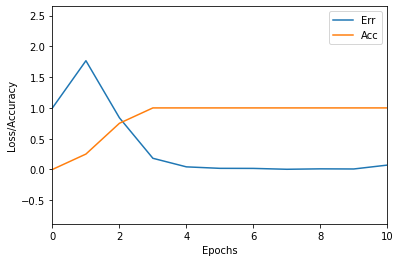

In [10]:
print("Ploting training loss ...")
plt.plot(errLoss, label="Err")
plt.plot(accLoss, label="Acc")
plt.xlim([0, len(errLoss)-1])
plt.legend(loc='upper right')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epochs')
plt.margins(0.5, 0.5)
plt.show()

**Testing the model:**

In [11]:
print("Testing the model ...")
acc = model.evaluate(Xtest, Ytest, batch_size=batchSize)
#print(model.metrics_names)
print("\tTop-1 Accuracy: %f" % acc[1])

Testing the model ...
16/16 [==============================] - 5s 252ms/step - loss: 2.0137 - accuracy: 0.5740
	Top-1 Accuracy: 0.574000
